In [4]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Categorical Attributes

## Categorical Attributes

**Let's switch to a different dataset (a toy one)**

<center><img src="assets/weather.jpg" width=50%></center>

* We want to train a model to choose whether to go out and play
* ...Based on weather conditions


## Loading the Data

**The dataset is in the `weather.csv` file from the `data` folder**

In [5]:
!dir data

SeoulBikeData.csv  real_estate.csv  weather.csv


In [6]:
import pandas as pd
data = pd.read_csv('data/weather.csv', sep=',')
data.head()

,outlook,temperature,humidity,windy,play
0,sunny,85,85,False,no
1,sunny,80,90,True,no
2,overcast,83,86,False,yes
3,rainy,70,96,False,yes
4,rainy,68,80,False,yes


* Several attributes _do not have a numeric value_
* Instead, their value is discrete with no clear ordering, i.e. _categorical_

**We need a _numeric encoding_ to handle this data with linear models**

## Encoding Binary Attributes

**Binary attributes can be encoded with the values 0 and 1**

This is the case for the columns "windy" and "play"

* First, we tell pandas that the columns have a categorical type

In [7]:
windy = data['windy'].astype('category')
play = data['play'].astype('category')
windy.head()

0    False
1     True
2    False
3    False
4    False
Name: windy, dtype: category
Categories (2, bool): [False, True]

* Categorical data is still _displayed as a string_
* ...But internally it is _encoded as an integer_

## Encoding Binary Attributes

**Next, we replace the values with their integer code**

We will store the results in a copy of the original table

In [8]:
data2 = data.copy() # We prepare a cop for the numeric encodings
data2['windy'] = windy.cat.codes
data2['play'] = play.cat.codes
data2.head()

,outlook,temperature,humidity,windy,play
0,sunny,85,85,0,0
1,sunny,80,90,1,0
2,overcast,83,86,0,1
3,rainy,70,96,0,1
4,rainy,68,80,0,1


* Now it is apparent that "windy" and "play" have become numbers

## Encoding Discrete Attributes

**We could use the same approach for discrete attribute in general**

E.g. for the attribute "outlook" in our table

* That would yield a numeric _integer_ encoding
* ...Which implies an ordering among the values (e.g. rainy < overcast < sunny)
* When no such ranking exists, this is a bad idea

**In these cases, it is better to adopt a one-hot encoding**

* We introduce a column for each value $v_k$ of the attribute $xj$
* The column contains a 1 iff $x_j = v_k$, and 0 otherwise

For example, "sunny | sunny | overcast" becomes:

rainy | overcast | sunny
:----:|:--------:|:-----:
  0   |    0     |   1
  0   |    0     |   1
  0   |    1     |   0

## Encoding Discrete Attributes

**We can obtain a one-hot encoding in pandas via the `get_dummies` method**

In [9]:
data3 = pd.get_dummies(data2, columns=['outlook'])
data3.head()

,temperature,humidity,windy,play,outlook_overcast,outlook_rainy,outlook_sunny
0,85,85,0,0,0,0,1
1,80,90,1,0,0,0,1
2,83,86,0,1,1,0,0
3,70,96,0,1,0,1,0
4,68,80,0,1,0,1,0


* The method by default processes all columns with categorical or object type
  - Strings in csv files are often parsed as "object" columns
* `get_dummies` can also handle the special case of binary variables
  - ...But I wanted to show you how to obtain an integer encoding, too :-)

# Logistic Regression

## Logistic Regression

**Our goal is to predict the value of "play", i.e. _a categorical attribute_**

We say that we are dealing with _a classification problem_

* This is second type of ML _task_
* I.e. another broad definition of an ML problem

**Classification problem can be tackled via Linear Models**

...Via a relatively simple modification

* However, even if it looks like a simple mathematical "hack"
* ...The modification has a strong theoretical basis!

We will discuss this topic a bit in this lecture

**Classification and regression have a distinct statistical foundation**

## Logistic Regression

**A linear model for classification can be obtained as follows:**

* First, we compute the output as usual:
$$
g(x; w) = \sum_{j=1} w_j x_j + w_0
$$ 
* ...But then we feed it to a _logistic function_:
$$
\frac{1}{1 + e^{-x}}
$$


Overall, we obtain:
$$
f(x; w) = \frac{1}{1 + e^{-g(x; w)}}
$$

## Logistic Regression

**The logistic function is a type of _sigmoid_ function**

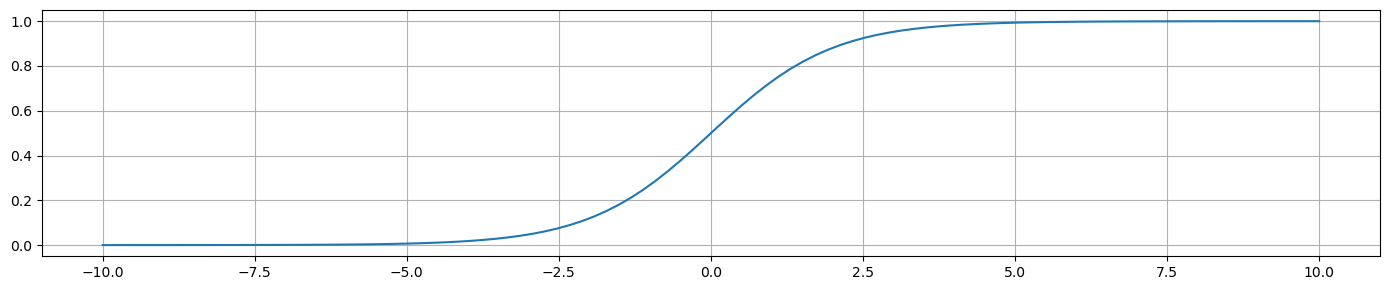

In [12]:
import numpy as np
from matplotlib import pyplot as plt
x = np.linspace(-10, 10, 100)
plt.figure(figsize=(14, 3))
plt.plot(x, 1 / (1 + np.exp(-x)))
plt.tight_layout(); plt.grid(':')

* Due to its use, this approach is known as _logistic regression_

## Logistic Regression

**Why using the logistic function?**

* We can view the model output as a probability distribution
* Specifically, as _the probability of the class being "1"_

**With this convention, the target can also be interpreted as a probability**

In [14]:
data3['play'].head()

0    0
1    0
2    1
3    1
4    1
Name: play, dtype: int8

We view:

* $y_i = 0$ as "the probability of the class being 1 is equal to 0"
* $y_i = 1$ as "the probability of the class being 1 is equal to 1"

## Maximum Likelihood Estimation

**This detail is important because it defines how we perform training**

The process relies on a _change of perspective_

* We pretend that our model is a _data generator_
* ...And compute a formula for the _chance of generating the training set_

This formula is called a _likelihood function_

**From this perspective:**

* Training means to change the model parameters $w$
* ...So that generating the training set is _as likely as possible_

**This approach is known as Maximum Likelihood Estimation**

* We will see how it can be applied to Logistic Regression
* It's going to be hard: if you get lost, try to understand at least the main idea

## Maximum Likelihood Estimation

**If we assume that $f(x; w)$ is the source of our data**

...Then, when we have (e.g.) $f(x; w) = 0.7$:

* We will generate a 1 with 70% chance
* We will generate a 0 with 30% chance

**Now we can measure the chance that the model makes the right guess:**

* If the label is 1, i.e. $y_i = 1$
  - We will generate that with a $f(x; w)$ probability
* If the label is 0, i.e. $y_i = 0$
  - We will generate that with a $1-f(x; w)$ probability

## Likelihood Function

**If we repeat for all examples (assuming statistical independence)...**

We get the _the probability of correctly generating example in each class_.

* For all the examples where the class is 1, we get:
$$
\prod_{y_i=1} f(x_i; w)
$$
* For all the examples where the class is 0, we get:
$$
\prod_{y_i=0} (1-f(x_i; w))
$$

**Intuitively:**

* When we have $y_i = 1$, we want $f(x; w)$ to be _high_
* When we have $y_i = 0$, we want $f(x; w)$ to be _low_

## Likelihood Function

**With another product we get the chance of generating all the training data**

$$
L(w) = \prod_{y_i=1} f(x_i; w) \prod_{y_i=0} (1-f(x_i; w))
$$

* The is sort of a probability, but is _associated to our model_, not to the data itself
* ...And it also _depends on the parameters $w$_

This is an example of a _likelihood function_

**We want to train a model that is a _likely source for our data_**

This means that we can choose the weights by solving:
$$
\text{argmax}_w \log L(w)
$$
* I.e. to _maximize the likelihood_ of the data
* This often done via Gradient Descent

## Maximum Likelihood Estimation

> **MLE is very important in many Machine Learning approaches**

* It provides a _mathematical foundation_ for the training process
* It applies to linear regression, too!
* ...Since the MSE can be interpreted in terms of likelihood

**In practice, scikit-learn does all the heavy lifting for us**

...But understanding the main idea is still very useful

* If you feel confused, that's because likelihood is not an easy concept
* ...But it was worth to at least mention in

## Using Logistic Regression

**Using Logistic Regression in scikit-learn is actually easy**

We begin by splitting input/output data as usual:

In [10]:
cols_in = [c for c in data3.columns if c != 'play']

X = data3[cols_in]
y = data3['play']
y.head() # We have a table here, but a vector would also work

0    0
1    0
2    1
3    1
4    1
Name: play, dtype: int8

Then the training and test set: 

In [11]:
from sklearn.model_selection import train_test_split
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.34, random_state=0)

## Using Logistic Regression

**Then, we build a `LogisticRegression` model**

In [12]:
from sklearn.linear_model import LogisticRegression

m = LogisticRegression()

...And we call the `fit` method as usual:

In [13]:
m.fit(X_tr, y_tr);

Finally, we can obtain out predictions:

In [14]:
y_pred_tr = m.predict(X_tr)
y_pred_ts = m.predict(X_ts)

## A Better Look at the Predictions

**By default, the prediction is the class with the largest probability**

In [15]:
y_pred_tr

array([0, 1, 0, 0, 1, 0, 0, 1, 1], dtype=int8)

* If we are interested in the raw probability values...
* ...We can call the `predict_proba` method:

In [16]:
y_prob_tr = m.predict_proba(X_tr)
y_prob_tr[:5]

array([[0.726788  , 0.273212  ],
       [0.3675285 , 0.6324715 ],
       [0.77878844, 0.22121156],
       [0.77593317, 0.22406683],
       [0.48442041, 0.51557959]])

* Scikit-learn gives us the predicted probability of both classes
* Hence, we get two separate columns

## Evaluation

**We can evaluate the results using metrics**

There are four basic metrics for binary classification:

* Number of _True Positives_, i.e. $\mathit{TP} = \sum_{y_i=1} \tilde{f}(x_i; w)$
* Number of _True Negatives_, i.e. $\mathit{TN} = \sum_{y_i=0} (1 - \tilde{f}(x_i; w))$
* Number of _False Positives_, i.e. $\mathit{FP} = \sum_{y_i=0} \tilde{f}(x_i; w)$
* Number of _False Negatives_, i.e. $\mathit{FN} = \sum_{y_i=1} (1 - \tilde{f}(x_i; w))$

In all cases $\tilde{f}(x_i; w)$ is the most probable class for the example $x_i$



## Evaluation

**From these we can derive a few more complex metrics**

The model (binary) _accuracy_ is defined as:
$$
\mathit{ACC} = \frac{TP + TN}{m}
$$
* I.e. the fraction of examples that is _correctly classified_
* The accuracy ranges over the interval $[0, 1]$

In [17]:
from sklearn.metrics import accuracy_score

print(f'Accuracy on the training set: {accuracy_score(y_tr, y_pred_tr):.3}')
print(f'Accuracy on the test set: {accuracy_score(y_ts, y_pred_ts):.3}')

Accuracy on the training set: 0.778
Accuracy on the test set: 0.8


## Evaluation

**...Or we can plot all basic metrics via a _confusion matrix_**

Here's the one for the training set:

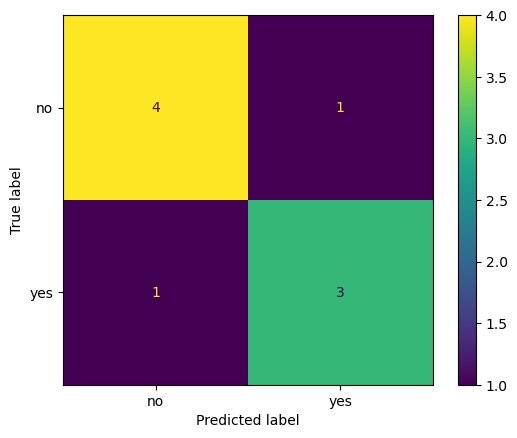

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(m, X_tr, y_tr, display_labels=play.cat.categories);

## Evaluation

**...Or we can plot all basic metrics via a _confusion matrix_**

...And the one for the test set

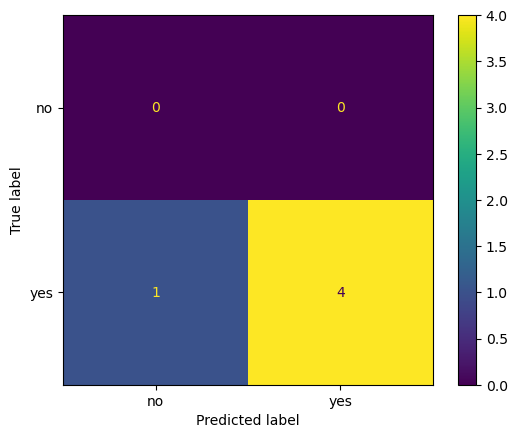

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(m, X_ts, y_ts, display_labels=play.cat.categories);

## Conclusions and Take-Home Messages

* Handling categorical attributes
  - _Binary_ attributes can be handled via 0-1 encoding
  - _Ordinal_ attributes via an integer encoding
  - _Categorical_ attributes via a one-hot encoding
* Logistic regression is a linear model for _classification_ tasks
  - The output can be interpreted as a _probability_
* Training for maximum likelihood
  - The _most common_ training method in the ML literature
  - Goal: _maximize the estimated probability_ of the training data
* Evaluation of classification models
  - Use _metrics_ for a compact evaluation
  - ...And a _confusion matrix_ to inspect the details